In [ ]:
! pip3 install transformers

     |████████████████████████████████| 4.0 MB 5.5 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 895 kB 45.7 MB/s 
     |████████████████████████████████| 6.5 MB 45.5 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [ ]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])
citation

,Text_Tokens,Cit_func,citseg_id


In [ ]:
import os
paths=[]
#d = "/content/per_func_map_organised_small_11class/all"
d="/content/drive/MyDrive/per_func_map_organised_small_11class/all"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

**Reading Data from dataset**

In [ ]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      left = citation_contexts[j]['left_ctx']
      left_tokens=[]
      for l in range(len(left)):
        left_tokens.append(left[l]['tokens_pp'])
      right = citation_contexts[j]['right_ctx']
      right_tokens=[]
      for r in range(len(right)):
        right_tokens.append(right[r]['tokens_pp'])
      
      left_tokens=[item for tokens in left_tokens for item in tokens]
      right_tokens=[item for tokens in right_tokens for item in tokens]
      l=len(left_tokens)
      tokens = left_tokens + tokens + right_tokens
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            c = c + l
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/drive/MyDrive/per_func_map_organised_small_11class/all/Future.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Support.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Basis.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoGM.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoRes.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoXY.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Motivation.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Neutral.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Similar.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_sm

**Joining Tokens of text**

In [ ]:
df=citation['Text_Tokens'].tolist()
str1 = [' '.join([str(i) for i in y]) for y in df]
citation['text']=str1

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text
0,"[Despite, their, large, length, difference, ,, the, two, 0002, sentences, are, still, aligned, as, a, 1, -, 1, pair, ,, because, the, sentences, in, the, following, 4, alignments, (, 0003, -, 0003, ;, 0004, -, 0004, ,, 0005, ;, 0005, -, 0006, ;, 0006, -, 0007, ), have, rather, similar, HTML, markups, and, are, taken, by, the, program, to, be, the, most, likely, alignments, ., Beside, HTML, mar...",Future,97,"Despite their large length difference , the two 0002 sentences are still aligned as a 1 - 1 pair , because the sentences in the following 4 alignments ( 0003 - 0003 ; 0004 - 0004 , 0005 ; 0005 - 0006 ; 0006 - 0007 ) have rather similar HTML markups and are taken by the program to be the most likely alignments . Beside HTML markups , other criteria may also be incorporated . For example , it wo..."
1,"[Previous, work, has, argued, that, initiative, affects, the, degree, of, control, an, agent, has, in, the, dialogue, interaction, (, CITSEG, ), ., Thus, ,, a, cooperative, system, may, adopt, different, strategies, to, achieve, the, same, goal, depending, on, the, initiative, distribution, ., Since, task, initiative, models, contribution, to, domain, /, problemsolving, goals, ,, while, dialog...",Future,84,"Previous work has argued that initiative affects the degree of control an agent has in the dialogue interaction ( CITSEG ) . Thus , a cooperative system may adopt different strategies to achieve the same goal depending on the initiative distribution . Since task initiative models contribution to domain / problemsolving goals , while dialogue initiative affects the cur -5 An alternative strateg..."
2,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,82,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
3,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,86,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
4,"[Future, work, will, involve, testing, our, approach, with, higher, -, discrimination, datasets, ,, developing, methods, to, pre-process, review, texts, (, e.g., ,, improved, negation, tagging, ,, and, incorporating, partof, -, speech, tagging, ), ,, and, further, addressing, the, problem, of, overfitting, ., To, this, effect, we, will, investigate, different, feature, selection, algorithms, ,...",Future,76,"Future work will involve testing our approach with higher - discrimination datasets , developing methods to pre-process review texts ( e.g. , improved negation tagging , and incorporating partof - speech tagging ) , and further addressing the problem of overfitting . To this effect we wi

**Visualising Citation Function Present**

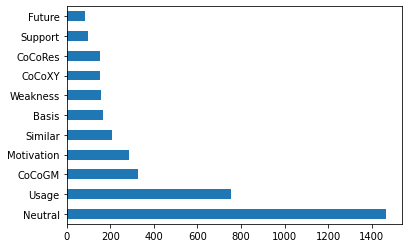

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

In [ ]:
display(citation.Cit_func.value_counts())             
print(" ")

Neutral       1463
Usage          755
CoCoGM         328
Motivation     288
Similar        207
Basis          167
Weakness       158
CoCoXY         152
CoCoRes        151
Support        100
Future          85
Name: Cit_func, dtype: int64

**Dropping some rows of Neutral and Usage functions**

In [ ]:
citation.drop(citation.query('Cit_func == "Neutral" ').sample(n=400).index,inplace=True)
citation.drop(citation.query('Cit_func == "Usage" ').sample(n=100).index,inplace=True)

In [ ]:
unique_labels = citation.Cit_func.unique()
unique_labels

array(['Future', 'Support', 'Basis', 'CoCoGM', 'CoCoRes', 'CoCoXY',
       'Motivation', 'Neutral', 'Similar', 'Usage', 'Weakness'],
      dtype=object)

**One- hot encoding for labels**

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(unique_labels)

citation['label'] = le.transform(citation.Cit_func)

In [ ]:
#Shuffling the dataframe
citation = citation.sample(frac=1).reset_index(drop=True)

**Splitting the dataset**

In [ ]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [ ]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1


for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


citation = pd.DataFrame(final_list)

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split
0,"[The, current, framework, offers, no, support, for, merging, handcrafted, rules, with, new, lexical, rules, obtained, statistically, while, preserving, the, valid, handcrafted, changes, and, deleting, the, invalid, ones, ., In, general, ,, a, better, integration, of, linguistically, based, and, statistical, methods, during, all, the, development, phases, is, greatly, needed, ., The, framework,...",Basis,79,"The current framework offers no support for merging handcrafted rules with new lexical rules obtained statistically while preserving the valid handcrafted changes and deleting the invalid ones . In general , a better integration of linguistically based and statistical methods during all the development phases is greatly needed . The framework represents a generalization of several predecessor ...",0,train
1,"[Therefore, ,, performing, the, clustering, with, a, vocabulary, that, is, large, enough, to, cover, the, many, named, entities, required, to, improve, the, accuracy, of, NER, is, difficult, ., We, enabled, such, large, -, scale, clustering, by, parallelizing, the, clustering, algorithm, ,, and, we, demonstrate, the, usefulness, of, the, gazetteer, constructed, ., We, parallelized, the, algori...",Basis,57,"Therefore , performing the clustering with a vocabulary that is large enough to cover the many named entities required to improve the accuracy of NER is difficult . We enabled such large - scale clustering by parallelizing the clustering algorithm , and we demonstrate the usefulness of the gazetteer constructed . We parallelized the algorithm of ( CITSEG ) using the Message Passing Interface (...",0,train
2,"[We, can, now, detect, and, correct, a, repair, ,, given, a, sentence, annotated, with, POS, tags, and, semantic, classes, ., But, how, can, we, construct, such, a, sequence, from, a, word, lattice, ?, Integrating, the, model, in, a, lattice, algorithm, requires, three, steps, :, mapping, the, word, lattice, to, a, tag, lattice, triggering, IPs, and, extracting, the, possible, reparandum, repa...",Basis,76,"We can now detect and correct a repair , given a sentence annotated with POS tags and semantic classes . But how can we construct such a sequence from a word lattice ? Integrating the model in a lattice algorithm requires three steps : mapping the word lattice to a tag lattice triggering IPs and extracting the possible reparandum reparans pairs introducing new paths to represent the plausible ...",0,train
3,"[The, process, study, most, similar, to, ours, is, that, of, CITSEG, ,, who, compared, scratch, ,, post-edit, ,, and, simple, interactive, modes, ., However, ,, he, used, undergraduate, ,, non-professional, subjects, ,, and, did, not, consider, re-tuning, ., Our, experimental, design, with, professional, bilingual, translators, follows, our, previous, work, CITSEG, comparing, scratch, translat...",Basis,49,"The process study most similar to ours is that of CITSEG , who compared scratch , post-edit , and simple interactive modes . However , he used undergraduate , non-professional subjects , and did not consider re-tuning . Our experimental design with professional bilingual translators follows our previous work CITSEG comparing scratch translation to post-edit . Many research translation UIs have...",0,train
4,"[Hyperparameters, ,, the, stickiness, factor, ,, and, the, frame, and, event, initial, and, transition, distributions, are, not, shown, for, clarity, ., |, |, |, |, |, |, −, Arguments, −, −, the, dependency, from, the, event, head, to, an, event, argument, dep, i, ,, j, ,, our, model, instead, emits, the, pair, of, event, head, and, dependency, relation, ,, which, we, call, a, caseframe, follo...",Basis,65,"Hyperparameters , the stickiness factor , and the frame and event initial and transition distributions are not shown for clarity . | | | | | | − Arguments − − the dependency from the event head to an event argument dep i , j , our model instead 

**Some visualizations after splitting the Dataset**

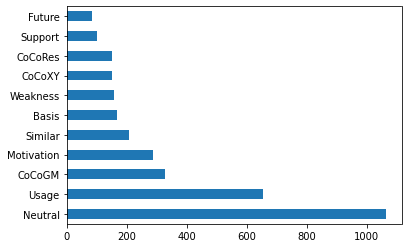

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

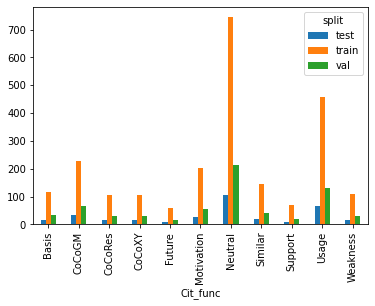

In [ ]:
citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [ ]:
citation.groupby(['Cit_func','split']).size()

Cit_func    split
Basis       test      16
            train    116
            val       33
CoCoGM      test      32
            train    229
            val       65
CoCoRes     test      15
            train    105
            val       30
CoCoXY      test      15
            train    106
            val       30
Future      test       8
            train     59
            val       17
Motivation  test      28
            train    201
            val       57
Neutral     test     106
            train    744
            val      212
Similar     test      20
            train    144
            val       41
Support     test      10
            train     70
            val       20
Usage       test      65
            train    458
            val      131
Weakness    test      15
            train    110
            val       31
dtype: int64

**Tokenizer**

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
special_tokens_dict = {'additional_special_tokens': ['CITSEG']}
tokenizer.add_special_tokens(special_tokens_dict=special_tokens_dict)

Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


0

**Splitting the dataset into three datasets: train, val, test**

In [ ]:
df_train = citation[citation.split=='train']
df_val = citation[citation.split=='val']
df_test= citation[citation.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2342, 6)
(667, 6)
(330, 6)


**Shuffling the data splits**

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Getting texts and labels**

In [ ]:
sentences_train = df_train.text.values
labels_train = df_train.label.values

sentences_valid = df_val.text.values
labels_valid = df_val.label.values

sentences_test = df_test.text.values
labels_test = df_test.label.values

**Creating input ids, attention masks**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]

In [ ]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 500)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 500)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 500)

In [ ]:
input_ids_train.shape

(2342, 500)

**Calculating position of Citseg in tokenised text**

In [ ]:
def calc_tok_cit_seg_id(df,input_id):
  cit_id=df['citseg_id'].values
  k=0
  tok_cid=[]
  for i in input_id:
    cit_seg_tok_id=-1
    #print(i)
    for j in i:
      #print(j)

      cit_seg_tok_id +=1
      if (j==1 and cit_seg_tok_id>= cit_id[k]):
        if(cit_seg_tok_id!= None):
          #print("cit_seg_tok_id for ", k ,"is: ", cit_seg_tok_id)
          tok_cid.append(cit_seg_tok_id)
          #print(k,len(tok_cid))
        else:
          print("no citseg")
        break
    k+=1
  #print(k)
  return tok_cid

In [ ]:
id_train= calc_tok_cit_seg_id(df_train,input_ids_train)
id_val= calc_tok_cit_seg_id(df_val,input_ids_valid) 
id_test= calc_tok_cit_seg_id(df_test,input_ids_test)

In [ ]:
len(id_train)

2342

**Adding Citseg position to Dataframes**

In [ ]:
df_train.loc[:,'tok_citseg_id']=id_train
df_test['tok_citseg_id']=id_test
df_val.loc[:,'tok_citseg_id']=id_val

In [ ]:
df_train.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[For, instance, ,, parsing, noun, compounds, appears, to, require, detailed, world, knowledge, that, is, unavailable, outside, a, limited, domain, (, CITSEG, ), ., Yet, ,, far, from, being, an, obscure, ,, endangered, species, ,, the, noun, compound, is, flourishing, in, modern, language, ., It, has, already, made, five, appearances, in, this, paragraph, and, at, least, one, diachronic, study,...",Neutral,64,"For instance , parsing noun compounds appears to require detailed world knowledge that is unavailable outside a limited domain ( CITSEG ) . Yet , far from being an obscure , endangered species , the noun compound is flourishing in modern language . It has already made five appearances in this paragraph and at least one diachronic study shows a veritable population explosion ( CITSEG ) . While ...",6,train,72
1,"[The, resource, -, based, approach, to, semantic, composition, in, Lexical, -, Functional, Grammar, (, LFG, ), obtains, the, interpretation, for, a, phrase, via, a, logical, deduction, ,, beginning, with, the, interpretations, of, its, parts, as, premises, (, CITSEG, ), ., The, resource, -, sensitive, system, of, linear, logic, is, used, to, compute, meanings, in, accordance, with, relationshi...",Neutral,83,"The resource - based approach to semantic composition in Lexical - Functional Grammar ( LFG ) obtains the interpretation for a phrase via a logical deduction , beginning with the interpretations of its parts as premises ( CITSEG ) . The resource - sensitive system of linear logic is used to compute meanings in accordance with relationships manifest in LFG f-structures . The properties of the s...",6,train,91
2,"[For, training, from, a, hand, -, tagged, corpus, ,, the, model, is, estimated, by, counting, the, number, of, transitions, from, each, tag, i, to, each, tag, j, ,, the, total, occurrence, of, each, tag, i, ,, and, the, total, occurrence, of, word, w, with, tag, i., Writing, these, as, f(, i, ,, j, ), ,, f(, i, ), and, f(, i, ,, w, ), respectively, ,, the, transition, probability, from, tag, i...",Neutral,120,"For training from a hand - tagged corpus , the model is estimated by counting the number of transitions from each tag i to each tag j , the total occurrence of each tag i , and the total occurrence of word w with tag i. Writing these as f( i , j ) , f( i ) and f( i , w ) respectively , the transition probability from tag i to tag j is estimated as f( i , j ) / f ( i ) and the lexical probabili...",6,train,130
3,"[So, ,, the, word, -, based, metrics, compare, individual, words, of, the, two, sentences, in, terms, of, their, morphological, paradigms, ,, synonyms, ,, hyperonyms, ,, hyponyms, ,, antonyms, ,, pos, tags, ..., [, CITSEG, ], or, use, a, semantic, distance, d, (, 0, ~, d, <l, ), which, is, determin, M, by, the, Most, Specific, Common, Abstraction, (, MSCA, ), obtained, from, a, thesaurus, abst...",Neutral,120,"So , the word - based metrics compare individual words of the two sentences in terms of their morphological paradigms , synonyms , hyperonyms , hyponyms , antonyms , pos tags ... [ CITSEG ] or use a semantic distance d ( 0 ~ d <l ) which is determin M by the Most Specific Common Abstraction ( MSCA ) obtained from a thesaurus abstraction hierarchy [ CITSEG ] . Then , a similarity metric is devi...",6,train,134
4,"[The, three, rule, types, used, in, the, first, set, of, experiments, are, standard, CFG, rules, ,, our, version, of, LP, /, ID, rules, ,, and, 2, nd, order, Markov, CFG, rules, ., The, second, battery, of, experiments, was, performed, on, the, model, with, Markov, rules, ., In, both, cases, ,, we, report, PARSEVAL, labeled, bracket, scores, (, CITSEG, ), ,, with, the, brackets, labeled, by, s...",Usage,57,"The three rule types used in the first set of experiments are standard CFG rules , our version of LP / ID rules , and 2 nd order Markov CFG rules . The second battery of experiments was performed on the mode

In [ ]:
df_val.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, grammar, is, a, manually, developed, headed, context, -, free, phrase, structure, grammar, for, German, subordinate, clauses, with, 5508, rules, and, The, formalism, is, that, of, CITSEG, ,, henceforth, C+R:, mother, ->, non, -, heads, head, ', non-heads, (, freq, ), The, rules, are, head, marked, with, a, prime, ., The, non, -, head, sequences, may, be, empty, ,, freq, is, a, rule, freq...",Usage,26,"The grammar is a manually developed headed context - free phrase structure grammar for German subordinate clauses with 5508 rules and The formalism is that of CITSEG , henceforth C+R: mother -> non - heads head ' non-heads ( freq ) The rules are head marked with a prime . The non - head sequences may be empty , freq is a rule frequency , which is initialized randomly and subsequently estimated...",9,val,30
1,"[1, ., A, transformation, of, the, written, messages, into, orthographically, and, syntactically, correct, utterances, ., This, was, necessary, for, the, parser, (, see, below, ), to, perform, with, an, adequate, accuracy, ., 2, ., Utterances, were, segmented, into, sentences, and, then, parsed, with, the, Stanford, Parser, (, CITSEG, ), ,, using, the, German, version, trained, on, the, Negra,...",Usage,47,"1 . A transformation of the written messages into orthographically and syntactically correct utterances . This was necessary for the parser ( see below ) to perform with an adequate accuracy . 2 . Utterances were segmented into sentences and then parsed with the Stanford Parser ( CITSEG ) , using the German version trained on the Negra corpus ( CITSEG ) . 3 . Syntactic and semantic properties ...",9,val,52
2,"[Systemic, grammar, assumes, multifunctional, constituent, structuresrepresentable, as, feature, structures, with, coreferences, ., As, shown, in, the, following, function, structure, example, for, the, sentence, "", The, people, that, buy, silver, love, it, ., "", ,, different, functions, can, be, filled, by, one, and, the, same, constituent, :, Given, the, notational, equivalence, of, HPSG, an...",Neutral,71,"Systemic grammar assumes multifunctional constituent structuresrepresentable as feature structures with coreferences . As shown in the following function structure example for the sentence "" The people that buy silver love it . "" , different functions can be filled by one and the same constituent : Given the notational equivalence of HPSG and systemic grammar first mentioned by ( CITSEG ) and ...",6,val,77
3,"[One, cannot, directly, compare, the, two, systems, from, the, descriptions, given, in, CITSEG, ,, as, the, results, in, the, descriptions, were, based, on, different, data, sets, and, on, different, assumptions, of, what, is, known, and, what, needs, to, be, found, ., Here, we, test, how, well, the, systems, perform, using, the, same, small, annotated, training, set, ,, the, 3299, words, of, ...",Usage,69,"One cannot directly compare the two systems from the descriptions given in CITSEG , as the results in the descriptions were based on different data sets and on different assumptions of what is known and what needs to be found . Here we test how well the systems perform using the same small annotated training set , the 3299 words of elementary school reading comprehension test bodies used in CI...",9,val,71
4,"[*, Morphosyntactic, Issues, In, broken, plurals, ,, diminutives, and, deverbal, nouns, ,, the, user, may, enter, a, morphologically, sound, ,, but, morphosyntactically, ill, -, formed, word, ., We, shall, discuss, this, in, more, detail, in, section, 4, ., 4, To, the, above, ,, one, adds, language, -, independent, issues, in, spell, checking, such, as, the, four, Damerau, transformations, :, ...",Neutral,67,"* Morphosyntactic Issues In broken plurals , diminutives and deverbal nouns , the user may enter a morphologically sound , but morphosyntactically ill - formed word . We shall discuss this in more detail in section 4 . 

In [ ]:
df_test.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[w∈segGEN, (, c, ), |, w|, i, =, 1, score, (, w, i, ), ., where, function, seg, GEN, maps, character, sequence, c, to, the, set, of, all, possible, segmentations, of, c, ., For, example, ,, w, =, (, c, 1, ..c, l, 1, ), ..., (, c, n−l, k, +, 1, ...c, n, ), represents, a, segmentation, of, k, words, and, the, lengths, of, the, first, and, last, word, are, l, 1, and, l, k, respectively, ., In, ea...",Neutral,100,"w∈segGEN ( c ) | w| i = 1 score ( w i ) . where function seg GEN maps character sequence c to the set of all possible segmentations of c . For example , w = ( c 1 ..c l 1 ) ... ( c n−l k + 1 ...c n ) represents a segmentation of k words and the lengths of the first and last word are l 1 and l k respectively . In early work , rule - based models find words one by one based on heuristics such as...",6,test,115
1,"[We, are, particularly, interested, in, how, the, different, phases, interact, ,, 1, ), because, one, major, way, to, expand, the, system, is, to, add, different, exercises, and, incorporate, them, into, the, second, phase, ,, and, 2, ), because, the, results, in, table, 6, show, a, strong, interdependence, between, phases, ., We, thus, performed, a, set, of, experiments, to, gauge, the, effec...",Neutral,85,"We are particularly interested in how the different phases interact , 1 ) because one major way to expand the system is to add different exercises and incorporate them into the second phase , and 2 ) because the results in table 6 show a strong interdependence between phases . We thus performed a set of experiments to gauge the effect of different types of features . By running ablation studie...",6,test,94
2,"[Performance, of, POS, tagging, is, an, important, factor, in, our, methods, because, they, are, based, on, word, /, POS, sequences, ., Existing, POS, taggers, might, not, perform, well, on, non-native, English, texts, because, they, are, normally, developed, to, analyze, native, English, texts, ., Considering, this, ,, we, tested, CRFTagger, 6, on, non-native, English, texts, containing, vari...",Usage,62,"Performance of POS tagging is an important factor in our methods because they are based on word / POS sequences . Existing POS taggers might not perform well on non-native English texts because they are normally developed to analyze native English texts . Considering this , we tested CRFTagger 6 on non-native English texts containing various grammatical errors before the experiments ( CITSEG )...",9,test,70
3,"[Standard, numerical, methods, for, statistical, inference, of, log-linear, models, from, fully, annotated, data, so, -, called, complete, data, are, the, iterative, scaling, methods, of, CITSEG, and, Della, CITSEG, ., For, data, consisting, of, unannotated, sentences, so-called, incomplete, data, the, iterative, method, of, the, EM, algorithm, (, CITSEG, ), has, to, be, employed, ., However, ...",Neutral,24,"Standard numerical methods for statistical inference of log-linear models from fully annotated data so - called complete data are the iterative scaling methods of CITSEG and Della CITSEG . For data consisting of unannotated sentences so-called incomplete data the iterative method of the EM algorithm ( CITSEG ) has to be employed . However , since even complete - data estimation for log - linea...",6,test,27
4,"[Different, encodings, were, provided, ,, and, the, UTF8, data, for, all, four, corpora, were, used, in, this, experiment, ., Following, the, format, of, Table, 5, ,, the, results, for, this, bakeoff, are, shown, in, Table, 6, ., We, chose, the, three, models, that, achieved, at, least, one, best, score, in, the, closed, tests, from, CITSEG, ,, as, well, as, the, sub-word, -, based, model, of,...",CoCoRes,65,"Different encodings were provided , and the UTF8 data for all four corpora were used in this experiment . Following the format of Table 5 , the results for this bakeoff are shown in Table 6 . We chose the three mo

**Create torch tensors required for DataLoader**

In [ ]:

train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
citseg_train_inputs=torch.tensor(id_train)
test_inputs = torch.tensor(input_ids_test)


train_labels = torch.tensor(df_train.label.values)
validation_labels = torch.tensor(df_val.label.values)
citseg_validation_inputs=torch.tensor(id_val)
test_labels = torch.tensor(df_test.label.values)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
citseg_test_inputs=torch.tensor(id_test)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels,citseg_train_inputs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,citseg_validation_inputs)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels,citseg_test_inputs)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Custom SciBert Model**

In [ ]:
#Create custom scibert model for sequence classification
class CustomSciBERTModel(nn.Module):
    def __init__(self):
      super(CustomSciBERTModel, self).__init__()
      self.scibert = BertModel.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
      self.num_labels = 11
      self.dropout = nn.Dropout(0.3)
      self.linear_layer = nn.Linear(768, 11)
     

    def forward(self, ids, mask, labels,citseg_id):
      output = self.scibert(
            input_ids=ids, 
            attention_mask=mask)
      last_hidden_states = output[0]
      
      #gather function
      batch_size,columns=ids.shape
      citseg_id = citseg_id.view(batch_size,1,1)
      citseg_id = citseg_id.repeat(1,1,768)
      pooled_states2 = torch.gather(input=last_hidden_states, dim=1, index=citseg_id)
      #print("pooled_states2:", pooled_states2)
      citseg_feature_vector = torch.squeeze(pooled_states2, dim=1)


      #logits = self.dropout(output[1])
      #logits = self.linear_layer(logits[1])
      logits = self.linear_layer(citseg_feature_vector) 

      loss = None
      # while training return loss and while validation/ testing resturn logits
      if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss
      else:
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create model object
model = CustomSciBERTModel()

# Get model on to GPU
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of epochs
epochs = 20

# training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at /content/drive/MyDrive/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depre

In [ ]:
# Compute accuracy
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def macroscore(preds,labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  val_macro_f1_score = f1_score(labels, pred, average='macro')
  return val_macro_f1_score 

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

true, pred = [], []

predictions=[]
prediction=[]
y=[]

# Store the average loss after each epoch so we can plot them.
training_loss_values = []
validation_loss_values= []

# set initial loss to infinite
best_valid_loss = float('inf')

# store predictions on validation data
valid_preds = []

max_val_f1_score=0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: citseg ids 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_citseg_id=batch[3].to(device)
        

        # backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Forward pass
        outputs = model(ids = b_input_ids, mask = b_input_mask, labels = b_labels, citseg_id=b_citseg_id)
        
        # forward pass gives loss as output
        loss = outputs

        # accumulate loss
        total_loss += loss.item()

        # backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    training_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Reset the total validation loss for this epoch.
    total_valid_loss = 0

    # evaluation mode.
    model.eval()

    # evaluation loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    running_loss, running_acc= 0 , 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels,b_citseg_id = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # It gives logits when labels are not given to model
            outputs = model(b_input_ids, 
                            b_input_mask, labels = None, citseg_id=b_citseg_id)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs

        # Track the number of batches
        nb_eval_steps += 1

        # compute the loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (nb_eval_steps)    

        # Calculate the average loss over the validating data.
        # accumulate loss
        total_valid_loss += loss.item()
        avg_valid_loss = total_valid_loss / len(validation_dataloader)
         
         #save the best model
        if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt') 

        

        #appending predictions and true labels for last epoch
        if(epoch_i==epochs-1):
          _, predictions = logits.max(dim=1)
          prediction.append(predictions)
          y.append(b_labels)

        #compute the accuracy
        acc_t = compute_accuracy(logits, b_labels)
        running_acc += (acc_t - running_acc) / (nb_eval_steps)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        valid_preds.extend(np.argmax(logits, axis=1).flatten())
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        #calculate macro f1 score
        val_f1_score=macroscore(logits, label_ids)

        if val_f1_score>max_val_f1_score:
          max_val_f1_score=val_f1_score

        

    # Store the loss value for plotting the learning curve.
    validation_loss_values.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average Validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("The Val macro f1 score is: ", max_val_f1_score)
    print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_i, running_loss, running_acc))
      
    

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 1.72
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 0.61
  Average Validation loss: 1.28
  Validation took: 0:00:14
The Val macro f1 score is:  0.8482905982905983
Epoch 0	 val_loss=1.278753743285225	 val_acc=61.25541125541126

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 1.01
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 0.69
  Average Validation loss: 0.95
  Validation took: 0:00:14
The Val macro f1 score is:  0.9206349206349206
Epoch 1	 val_loss=0.9544961636974698	 val_acc=68.84469696969697

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:

In [ ]:
training_loss_values 

[1.7185588041130377,
 1.0126702475304505,
 0.5880172923714125,
 0.320619887387266,
 0.15940875693724876,
 0.07086052164691975,
 0.04964319786704684,
 0.03779791780077491,
 0.0289487762605933,
 0.024849390585710403,
 0.01865191413224263,
 0.02025178591112945,
 0.016945739883135965,
 0.01587296515342076,
 0.01390128255733463,
 0.01338570060058565,
 0.013406959152463697,
 0.010795722631709873,
 0.009909544302893843,
 0.0072449319302001465]

In [ ]:
validation_loss_values

[1.2787537432852245,
 0.9544961636974698,
 0.9914896608818144,
 1.0438095529874165,
 1.2351013602955,
 1.5153352455014275,
 1.716121075763589,
 1.7311597532104879,
 1.7469234303349541,
 1.78656386974312,
 1.9062689666946728,
 1.8526860897739728,
 1.865792925513926,
 1.9124710598871821,
 1.9071736147715932,
 1.9202358052134514,
 1.9143362686570202,
 1.9104287044278212,
 1.9236359457884515,
 1.9209690257197334]

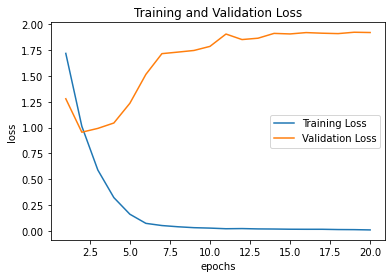

In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y1 = training_loss_values
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training Loss")
# line 2 points

y2 = validation_loss_values
# plotting the line 2 points 
plt.plot(x1, y2, label = "Validation Loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('Training and Validation Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
y.pop()

tensor([10,  9,  9,  6,  5,  9,  6,  9,  1, 10,  9], device='cuda:0')

In [ ]:
prediction.pop()

tensor([10,  9,  9,  6,  5,  9,  6,  9,  6, 10,  9], device='cuda:0')

In [ ]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [ ]:
true_y=y_tensor.cpu().detach().numpy()
pred_y=pred_tensor.cpu().detach().numpy()

In [ ]:
true_y.shape

(41, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"]
#'Future', 'Support', 'Basis', 'CoCoGM', 'CoCoRes', 'CoCoXY','Neutral', 'Motivation', 'Similar', 'Usage', 'Weakness'
print(classification_report(true_y, pred_y, target_names=target_names))


              precision    recall  f1-score   support

       Basis       0.77      0.61      0.68        33
      CoCoGM       0.75      0.78      0.76        64
     CoCoRes       0.76      0.87      0.81        30
      CoCoXY       0.65      0.43      0.52        30
      Future       0.68      0.88      0.77        17
  Motivation       0.76      0.68      0.72        56
     Neutral       0.74      0.77      0.76       210
     Similar       0.57      0.66      0.61        41
     Support       0.54      0.35      0.42        20
       Usage       0.80      0.77      0.78       126
    Weakness       0.56      0.69      0.62        29

    accuracy                           0.72       656
   macro avg       0.69      0.68      0.68       656
weighted avg       0.73      0.72      0.72       656



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[ 20,   1,   0,   0,   0,   0,   6,   0,   0,   6,   0],
       [  0,  50,   3,   0,   0,   0,   3,   5,   1,   0,   2],
       [  0,   1,  26,   1,   0,   0,   1,   0,   0,   1,   0],
       [  0,   2,   2,  13,   0,   1,   8,   0,   0,   2,   2],
       [  0,   0,   0,   0,  15,   0,   1,   0,   1,   0,   0],
       [  0,   0,   1,   0,   1,  38,  11,   2,   2,   0,   1],
       [  1,   4,   1,   5,   2,   6, 162,   5,   1,  14,   9],
       [  2,   5,   0,   1,   0,   0,   4,  27,   0,   1,   1],
       [  0,   0,   0,   0,   4,   1,   5,   2,   7,   0,   1],
       [  3,   2,   1,   0,   0,   3,  13,   6,   1,  97,   0],
       [  0,   2,   0,   0,   0,   1,   5,   0,   0,   1,  20]])

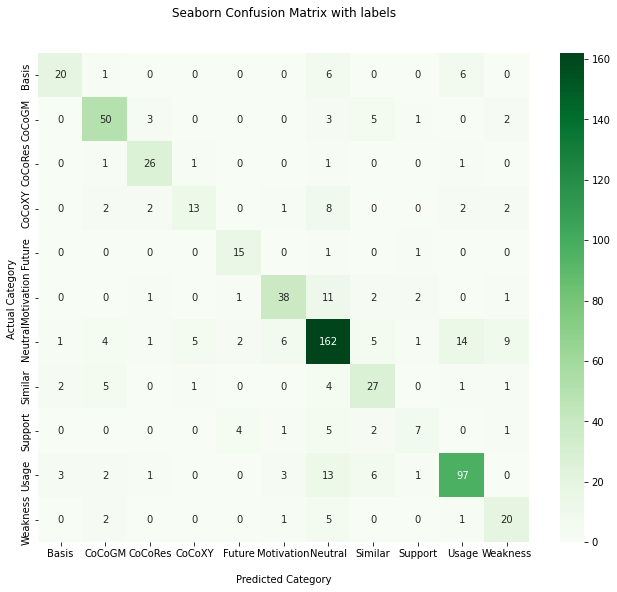

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])
ax.yaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])

## Display the visualization of the Confusion Matrix.
plt.show()

**Testing**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
tot_pred=[]
tot_labels=[]
input_ids=[]

for batch in test_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_citseg_id = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # It gives logits when labels are not given to model
        outputs = model(b_input_ids, 
                        b_input_mask, labels = None, citseg_id=b_citseg_id)
    
    # Get the "logits" output by the model. The "logits" are the output
    #logits = outputs
    _, logits = outputs.max(dim=1)
    tot_pred.append(logits)
    tot_labels.append(b_labels)
    input_ids.append(b_input_ids)

In [ ]:
tot_labels.pop()

tensor([2, 6, 8, 3, 9, 9, 9, 1, 6, 6], device='cuda:0')

In [ ]:
tot_pred.pop()

tensor([2, 6, 8, 6, 9, 9, 9, 1, 6, 9], device='cuda:0')

In [ ]:
input_ids.pop()

tensor([[ 102,  705,  422,  ...,    0,    0,    0],
        [ 102, 2647, 1865,  ...,    0,    0,    0],
        [ 102,  256,  112,  ...,    0,    0,    0],
        ...,
        [ 102,  982,    1,  ...,    0,    0,    0],
        [ 102, 1783,  697,  ...,    0,    0,    0],
        [ 102,  494, 1196,  ...,    0,    0,    0]], device='cuda:0')

In [ ]:
tot_labels_tensor = torch.stack(tot_labels)
tot_pred_tensor = torch.stack(tot_pred)
input_ids_tensor=torch.stack(input_ids)

In [ ]:
true_y=tot_labels_tensor.cpu().detach().numpy()
pred_y=tot_pred_tensor.cpu().detach().numpy()
input_id=input_ids_tensor.cpu().detach().numpy()

In [ ]:
sent=[]
for i in (input_ids_tensor):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [ ]:
true_y.shape

(20, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

              precision    recall  f1-score   support

       Basis       0.55      0.38      0.44        16
      CoCoGM       0.62      0.81      0.70        31
     CoCoRes       0.73      0.79      0.76        14
      CoCoXY       0.50      0.50      0.50        14
      Future       0.80      0.50      0.62         8
  Motivation       0.63      0.68      0.66        28
     Neutral       0.78      0.63      0.70       103
     Similar       0.50      0.65      0.57        20
     Support       0.71      0.56      0.63         9
       Usage       0.72      0.76      0.74        62
    Weakness       0.50      0.80      0.62        15

    accuracy                           0.67       320
   macro avg       0.64      0.64      0.63       320
weighted avg       0.68      0.67      0.67       320



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[ 6,  1,  1,  0,  0,  2,  1,  1,  0,  4,  0],
       [ 0, 25,  1,  0,  0,  1,  1,  1,  0,  2,  0],
       [ 0,  0, 11,  1,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  1,  7,  0,  0,  1,  0,  0,  2,  3],
       [ 0,  0,  0,  0,  4,  0,  3,  1,  0,  0,  0],
       [ 0,  2,  0,  1,  0, 19,  4,  0,  0,  2,  0],
       [ 2,  7,  0,  5,  1,  4, 65,  5,  0,  7,  7],
       [ 0,  2,  0,  0,  0,  0,  2, 13,  1,  1,  1],
       [ 0,  1,  0,  0,  0,  1,  1,  1,  5,  0,  0],
       [ 3,  1,  0,  0,  0,  2,  4,  4,  0, 47,  1],
       [ 0,  1,  1,  0,  0,  0,  1,  0,  0,  0, 12]])

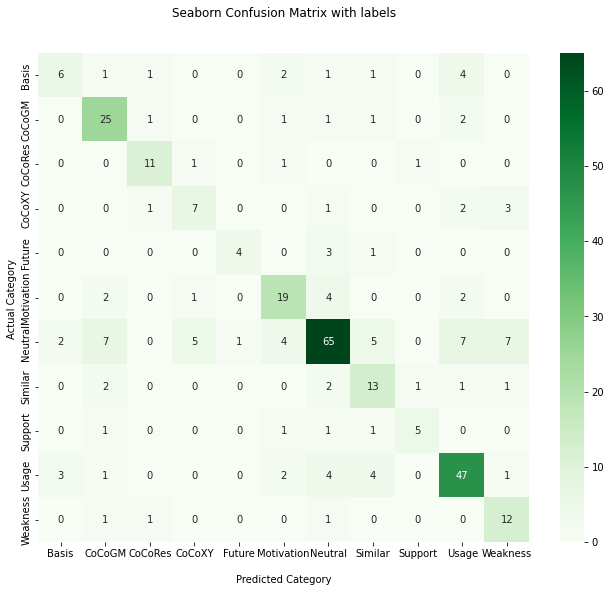

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])
ax.yaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
df=pd.DataFrame()
df['Actual Label']= true_y
df['Tokenised Text']=sent
df['predictions']= pred_y

In [ ]:
df['predictions'].replace({0: "Basis",1: "CoCoGM",2:  "CoCoRes", 3:"CoCoXY", 4: "Future", 5: "Motivation", 6: "Neutral", 7:"Similar", 8:"Support",9: "Usage", 10:"Weakness"}, inplace=True)
df['Actual Label'].replace({0: "Basis",1: "CoCoGM",2:  "CoCoRes", 3:"CoCoXY", 4: "Future", 5: "Motivation", 6: "Neutral", 7:"Similar", 8:"Support",9: "Usage", 10:"Weakness"}, inplace=True)

In [ ]:
df

,Actual Label,Tokenised Text,predictions
0,Neutral,"[[CLS], w, ##∈, ##seg, ##gen, (, c, ), |, w, |, i, =, 1, score, (, w, i, ), ., where, function, seg, gen, maps, character, sequence, c, to, the, set, of, all, possible, segmentation, ##s, of, c, ., for, example, ,, w, =, (, c, 1, ., ., c, l, 1, ), ., ., ., (, c, n, ##−, ##l, k, +, 1, ., ., ., c, n, ), represents, a, segmentation, of, k, words, and, the, lengths, of, the, first, and, last, word...",Neutral
1,Neutral,"[[CLS], we, are, particularly, interested, in, how, the, different, phases, interact, ,, 1, ), because, one, major, way, to, expand, the, system, is, to, add, different, exercises, and, incorporate, them, into, the, second, phase, ,, and, 2, ), because, the, results, in, table, 6, show, a, strong, inter, ##dependence, between, phases, ., we, thus, performed, a, set, of, experiments, to, gauge,...",Usage
2,Usage,"[[CLS], performance, of, pos, tagging, is, an, important, factor, in, our, methods, because, they, are, based, on, word, /, pos, sequences, ., existing, pos, tag, ##gers, might, not, perform, well, on, non, -, native, english, texts, because, they, are, normally, developed, to, analyze, native, english, texts, ., considering, this, ,, we, tested, crf, ##tag, ##ger, 6, on, non, -, native, engli...",Usage
3,Neutral,"[[CLS], standard, numerical, methods, for, statistical, inference, of, log, -, linear, models, from, fully, annotated, data, so, -, called, complete, data, are, the, iterative, scaling, methods, of, CITSEG, and, della, CITSEG, ., for, data, consisting, of, una, ##nn, ##ota, ##ted, sentences, so, -, called, incomplete, data, the, iterative, method, of, the, em, algorithm, (, CITSEG, ), has, to,...",Neutral
4,CoCoRes,"[[CLS], different, encoding, ##s, were, provided, ,, and, the, ut, ##f, ##8, data, for, all, four, corpora, were, used, in, this, experiment, ., following, the, format, of, table, 5, ,, the, results, for, this, bak, ##e, ##off, are, shown, in, table, 6, ., we, chose, the, three, models, that, achieved, at, least, one, best, score, in, the, closed, tests, from, CITSEG, ,, as, well, as, the, sub...",CoCoRes
5,Weakness,"[[CLS], although, they, used, context, in, their, annotation, ,, their, focus, was, on, determining, the, author, ', s, reason, for, citi, ##ng, a, given, paper, ., this, task, differs, from, citation, sentiment, ,, which, is, in, a, sense, a, "", lower, level, "", of, analysis, ., for, implicit, citation, extraction, ,, CITSEG, explore, co, -, reference, chains, for, citation, extraction, using...",CoCoGM
6,Neutral,"[[CLS], green, ', s, algorithm, makes, use, of, discourse, expectations, ,, discourse, plans, ,, and, discourse, relations, ., the, following, dialog, is, considered, (, CITSEG, ), ,, p, ., answer, (, 17, ), convey, ##s, a, "", yes, "", ,, but, a, reply, consisting, only, of, (, 17, ), a, would, impl, ##icate, a, "", no, "", ., as, green, notice, ##s, ,, in, previous, models, of, impl, ##ica, ##tu...",Motivation
7,Neutral,"[[CLS], apr, ##olog, is, a, logic, programming, language, based, on, higher, -, order, hereditary, har, ##rop, formulae, (, CITSEG, ), ., it, differs, from, prol, ##og, in, that, first, -, order, terms, and, uni, ##fication, are, replaced, with, simply, -, typed, a, -, terms, and, higher, -, order, uni, ##fication, 7, ,, respectively, ., it, also, permits, universal, quantification, and, impli...",CoCoGM
8,Usage,"[[CLS], although, the, sentences, that, belong, to, the, same, cluster, are, similar, ,, they, are, not, necessarily, equally, important, ., we, rank, the, sentences, within, each, cluster, by, computing, their, lex, ##rank, (, CITSEG, ), ., sentences, with, higher, rank, are, more, important, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], ...",Usage
9,Neutral,"[[CLS], it, is, a, remarkable, fact, that, humans, can, often, understand, sentences, containing, unknown, words, ,, infer, their, grammatical, properties, and, increment